# 🧠 Multiscale CNN Training with GPU, TensorBoard, and Model Saving
This notebook includes GPU support, training time tracking, model saving, and TensorBoard visualization.

In [1]:
# 📦 1. Import Libraries and Check GPU
import os
import numpy as np
import pandas as pd
import zipfile 
from sklearn.model_selection import train_test_split
from scipy.stats import zscore
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Concatenate, GlobalAveragePooling2D, Dense,
    Reshape, Multiply
)
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import time

# GPU check and memory growth
print("🔍 TensorFlow version:", tf.__version__)
print("✅ GPU Available:", tf.config.list_physical_devices('GPU'))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✔️ Memory growth enabled")
    except RuntimeError as e:
        print("❌ Error setting memory growth:", e)
import tensorflow as tf
print(tf.test.is_built_with_cuda())

2025-05-24 10:42:16.256220: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-24 10:42:16.305405: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-24 10:42:16.958015: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


🔍 TensorFlow version: 2.12.0
✅ GPU Available: []
True


In [2]:
import pandas as pd

# Load the training data
train_df = pd.read_parquet('/share/home/jyren/ai_hwk1_janestreet/data/train.parquet')

# Display the first few rows and basic info (optional, for inspection)
print(train_df.head())
print(train_df.info())

   date_id  time_id  symbol_id    weight  feature_00  feature_01  feature_02  \
0        0        0          1  3.889038         NaN         NaN         NaN   
1        0        0          7  1.370613         NaN         NaN         NaN   
2        0        0          9  2.285698         NaN         NaN         NaN   
3        0        0         10  0.690606         NaN         NaN         NaN   
4        0        0         14  0.440570         NaN         NaN         NaN   

   feature_03  feature_04  feature_05  ...  responder_0  responder_1  \
0         NaN         NaN    0.851033  ...     0.738489    -0.069556   
1         NaN         NaN    0.676961  ...     2.965889     1.190077   
2         NaN         NaN    1.056285  ...    -0.864488    -0.280303   
3         NaN         NaN    1.139366  ...     0.408499     0.223992   
4         NaN         NaN    0.955200  ...    -0.373387    -0.502764   

   responder_2  responder_3  responder_4  responder_5  responder_6  \
0     1.380875  

In [3]:
missing = train_df.isnull().sum() * 100 / len(train_df)
missing = missing[missing > 0].sort_values(ascending=False)
print("\nMissing value percentages per feature:")
missing


Missing value percentages per feature:


feature_21    17.900406
feature_26    17.900406
feature_27    17.900406
feature_31    17.900406
feature_39     9.125593
feature_42     9.125593
feature_53     9.026816
feature_50     9.026816
feature_00     6.752030
feature_02     6.752030
feature_03     6.752030
feature_04     6.752030
feature_01     6.752030
feature_15     2.566024
feature_41     2.319274
feature_44     2.319274
feature_55     2.217180
feature_52     2.217180
feature_73     1.026493
feature_74     1.026493
feature_33     1.015243
feature_32     1.015243
feature_58     1.015232
feature_65     0.672992
feature_66     0.672992
feature_45     0.672992
feature_46     0.672992
feature_08     0.637097
feature_62     0.621353
feature_64     0.504300
feature_63     0.482875
feature_17     0.428282
feature_43     0.143984
feature_40     0.143984
feature_76     0.123983
feature_75     0.123983
feature_77     0.042529
feature_78     0.042529
feature_51     0.029293
feature_54     0.029293
feature_37     0.001802
feature_16     0

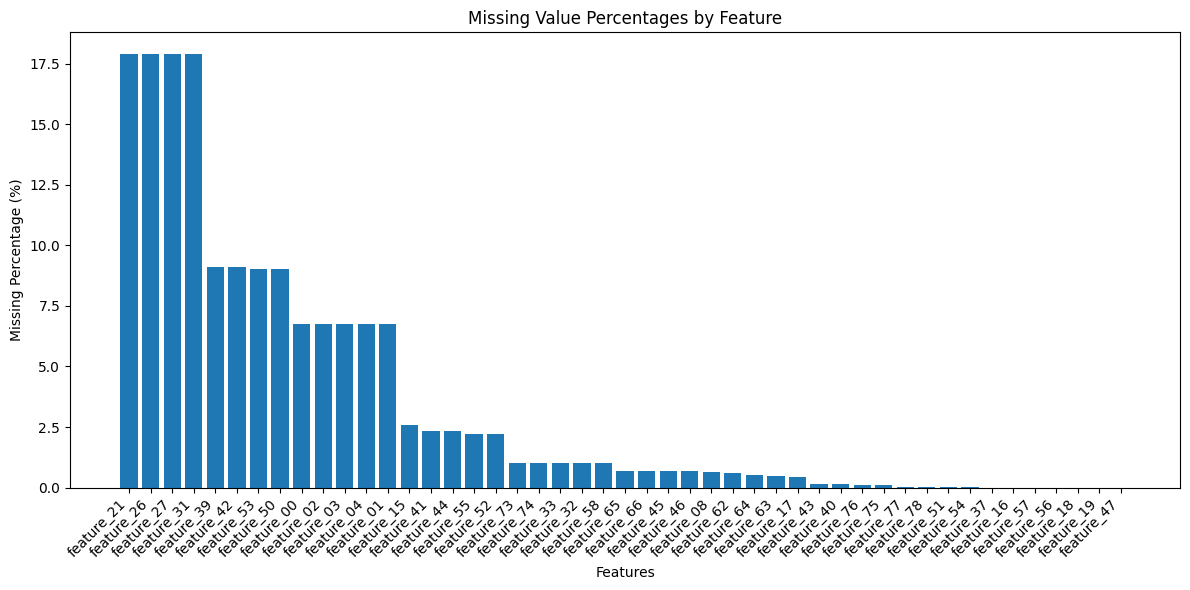

In [5]:
# 创建缺失率柱状图
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(missing.index, missing.values)
plt.xticks(rotation=45, ha='right')
plt.title('Missing Value Percentages by Feature')
plt.xlabel('Features')
plt.ylabel('Missing Percentage (%)')
plt.tight_layout()
plt.show()

In [20]:
# 📂 2. Data Functions
# def load_data(base_path, k):
#     data_frames = []
#     for i in range(k):
#         file_path = os.path.join(base_path, f"train_{i}.csv")
#         df = pd.read_csv(file_path)
#         data_frames.append(df)
#     return pd.concat(data_frames, ignore_index=True)
def load_data_from_zip(zip_file_path, k):
    data_frames = []
    with zipfile.ZipFile(zip_file_path, 'r') as zf:
        for i in range(k):
            # Assuming files are named train_0.csv, train_1.csv, etc. within the zip
            file_name_in_zip = f"train_{i}.csv"
            try:
                with zf.open(file_name_in_zip) as f:
                    df = pd.read_csv(f)
                    data_frames.append(df)
            except KeyError:
                print(f"Warning: {file_name_in_zip} not found in zip file.")
                continue # Skip to the next file if not found

    if not data_frames:
        raise ValueError("No data files found in the zip archive.")

    return pd.concat(data_frames, ignore_index=True)

def preprocess_data(df, target_col='responder_6'):
    missing_ratio = df.isnull().mean()
    df.drop(columns=missing_ratio[missing_ratio > 0.4].index, inplace=True)
    df.fillna(df.median(numeric_only=True), inplace=True)
    feature_cols = [col for col in df.columns if col.startswith('feature_')]
    return df, feature_cols, target_col

def mark_noise(features, window_size=20, step=10, std_multiplier=3):
    n_samples, _ = features.shape
    noise_flags = np.zeros(n_samples, dtype=bool)
    for i in range(0, n_samples - window_size + 1, step):
        window = features[i:i + window_size]
        stds = np.std(window, axis=0)
        if np.any(stds > std_multiplier * np.std(features, axis=0)):
            noise_flags[i:i + window_size] = True
    return noise_flags

In [21]:
# 📈 3. Create Image Data
def create_image_data(df, feature_cols, target_col, window_size=60, step=30, img_size=(60, 60)):
    features = df[feature_cols].apply(zscore).clip(-3, 3).values
    targets = df[target_col].values
    noise_labels = mark_noise(features, window_size, step)

    X_images, y_target, y_noise = [], [], []
    for i in range(0, len(df) - window_size + 1, step):
        window_feat = features[i:i + window_size]
        if window_feat.shape != img_size:
            window_feat = np.resize(window_feat, img_size)
        X_images.append(window_feat)
        y_target.append(targets[i + window_size - 1])
        y_noise.append(int(np.any(noise_labels[i:i + window_size])))

    X_images = np.array(X_images)[..., np.newaxis]
    return np.array(X_images), np.array(y_target), np.array(y_noise)

In [22]:
# 🧠 4. Build Model
def build_multiscale_cnn(input_shape):
    inputs = Input(shape=input_shape)
    feature_small = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    feature_large = Conv2D(32, (7, 7), activation='relu', padding='same')(inputs)
    combined = Concatenate(axis=-1)([feature_small, feature_large])

    se = GlobalAveragePooling2D()(combined)
    se = Dense(32, activation='relu')(se)
    se = Dense(64, activation='sigmoid')(se)
    se = Reshape((1, 1, 64))(se)
    weighted = Multiply()([combined, se])

    refined = Conv2D(64, (3, 3), activation='relu', padding='same')(weighted)
    pooled = GlobalAveragePooling2D()(refined)

    out_target = Dense(1, activation='sigmoid', name='target_output')(pooled)
    out_noise = Dense(1, activation='sigmoid', name='noise_output')(pooled)
    return Model(inputs, outputs=[out_target, out_noise])

In [23]:
# 🚀 5. Training with Timing, Saving, and TensorBoard
base_path = "data/jane-street-real-time-market-data-forecasting.zip"  # TODO: Replace this with actual path
df = load_data_from_zip(base_path, k=2)
df, feature_cols, target_col = preprocess_data(df)
X, y_target, y_noise = create_image_data(df, feature_cols, target_col)

X_train, X_test, y_train_t, y_test_t, y_train_n, y_test_n = train_test_split(
    X, y_target, y_noise, test_size=0.2, random_state=42
)

model = build_multiscale_cnn(input_shape=(60, 60, 1))
model.compile(
    optimizer='adam',
    loss={'target_output': 'binary_crossentropy', 'noise_output': 'binary_crossentropy'},
    loss_weights={'target_output': 1.0, 'noise_output': 0.3},
    metrics={'target_output': 'accuracy', 'noise_output': 'accuracy'}
)
model.summary()

# TensorBoard
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Training time tracking
start_time = time.time()
history = model.fit(
    X_train, {'target_output': y_train_t, 'noise_output': y_train_n},
    validation_data=(X_test, {'target_output': y_test_t, 'noise_output': y_test_n}),
    epochs=10,
    batch_size=64,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True), tensorboard_callback],
    verbose=1
)
end_time = time.time()
print(f"⏱️ Training completed in {(end_time - start_time):.2f} seconds")

# Save model
model.save("multiscale_cnn_model.h5")  # HDF5
model.save("multiscale_cnn_saved_model")  # TensorFlow SavedModel
print("✅ Model saved successfully")

ValueError: No data files found in the zip archive.